In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
data = pd.read_csv('../data/FuelConsumption.csv')


In [3]:
# Initial data inspection
print("Data shape:", data.shape)
print("\nFirst 5 rows:")
print(data.head())
print("\nData info:")
print(data.info())
print("\nSummary statistics:")
print(data.describe(include='all'))

# Drop leakage and non-useful columns
drop_cols = [
    "MODEL",  # High cardinality, behaves like an ID
    "FUELCONSUMPTION_CITY",
    "FUELCONSUMPTION_HWY",
    "FUELCONSUMPTION_COMB",  # This is likely a typo in the original code
    "FUELCONSUMPTION_COMB",
    "FUELCONSUMPTION_COMB_MPG",  # This is likely a typo in the original code
    "FUELCONSUMPTION_COMB_MPG"
]
data = data.drop(columns=[col for col in drop_cols if col in data.columns])

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

Data shape: (1067, 13)

First 5 rows:
   MODELYEAR   MAKE       MODEL VEHICLECLASS  ENGINESIZE  CYLINDERS  \
0       2014  ACURA         ILX      COMPACT         2.0          4   
1       2014  ACURA         ILX      COMPACT         2.4          4   
2       2014  ACURA  ILX HYBRID      COMPACT         1.5          4   
3       2014  ACURA     MDX 4WD  SUV - SMALL         3.5          6   
4       2014  ACURA     RDX AWD  SUV - SMALL         3.5          6   

  TRANSMISSION FUELTYPE  FUELCONSUMPTION_CITY  FUELCONSUMPTION_HWY  \
0          AS5        Z                   9.9                  6.7   
1           M6        Z                  11.2                  7.7   
2          AV7        Z                   6.0                  5.8   
3          AS6        Z                  12.7                  9.1   
4          AS6        Z                  12.1                  8.7   

   FUELCONSUMPTION_COMB  FUELCONSUMPTION_COMB_MPG  CO2EMISSIONS  
0                   8.5                        3

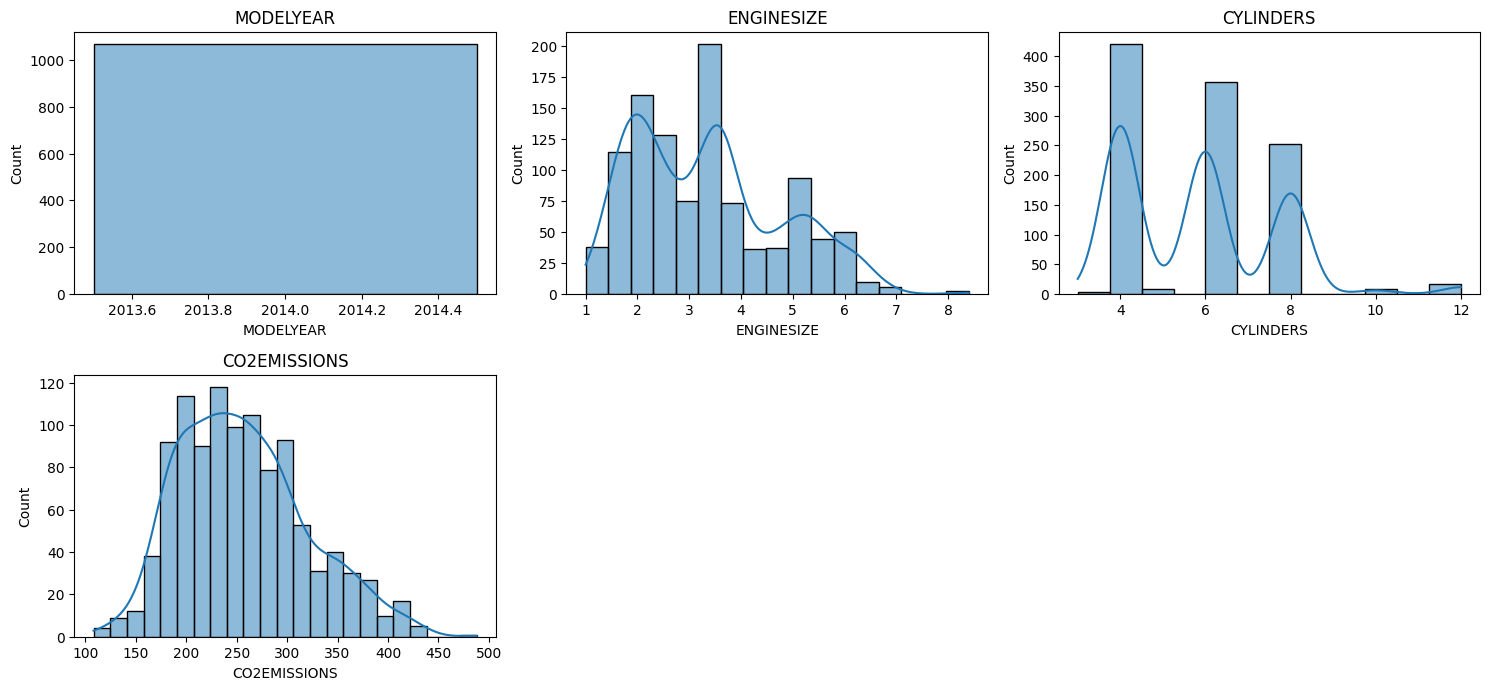

In [5]:
# EDA - Exploratory Data Analysis
plt.figure(figsize=(15, 10))

# Numeric features distribution
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
for i, col in enumerate(numeric_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(data[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

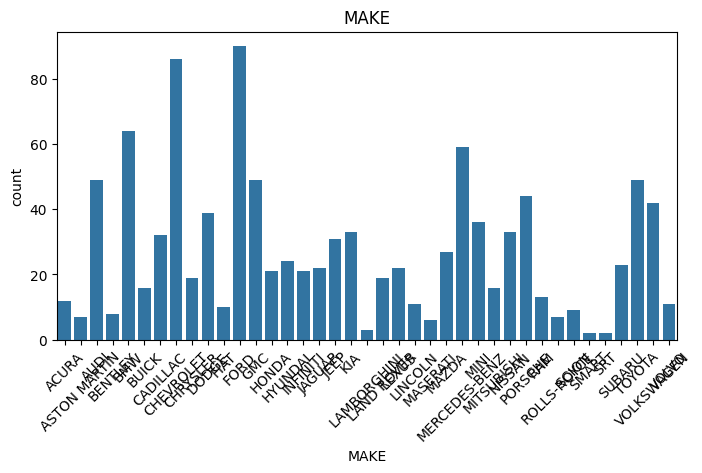

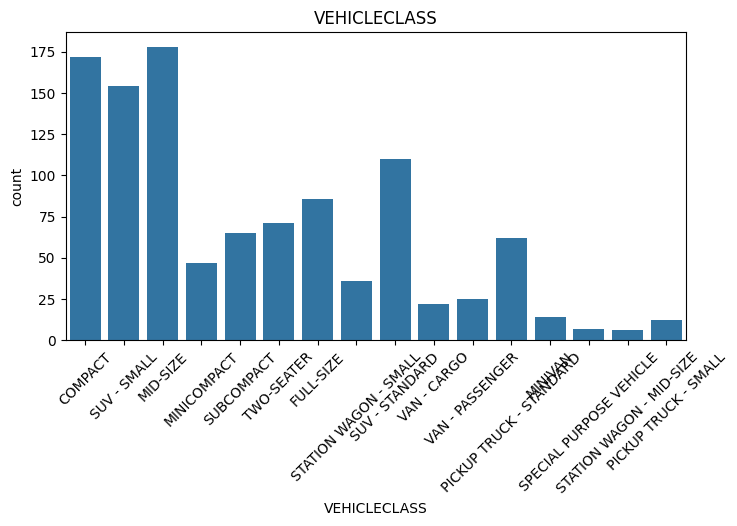

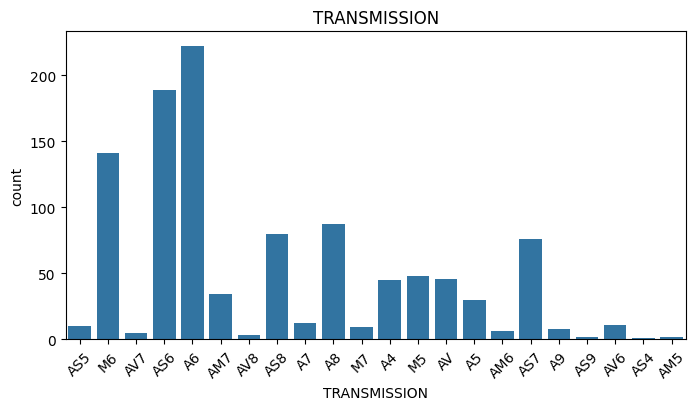

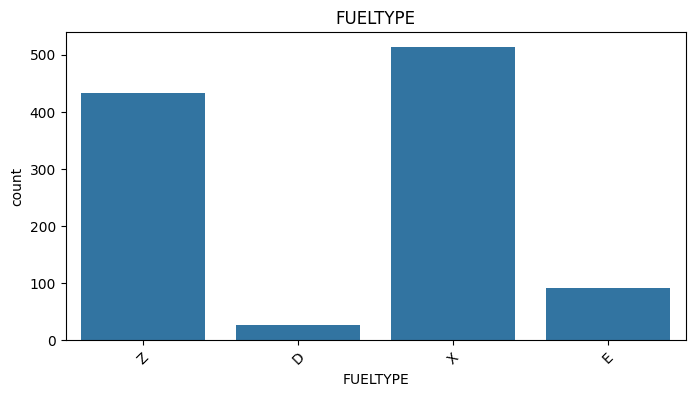

In [6]:
# Categorical features distribution
categorical_features = data.select_dtypes(include=['object']).columns
for col in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=data, x=col)
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()

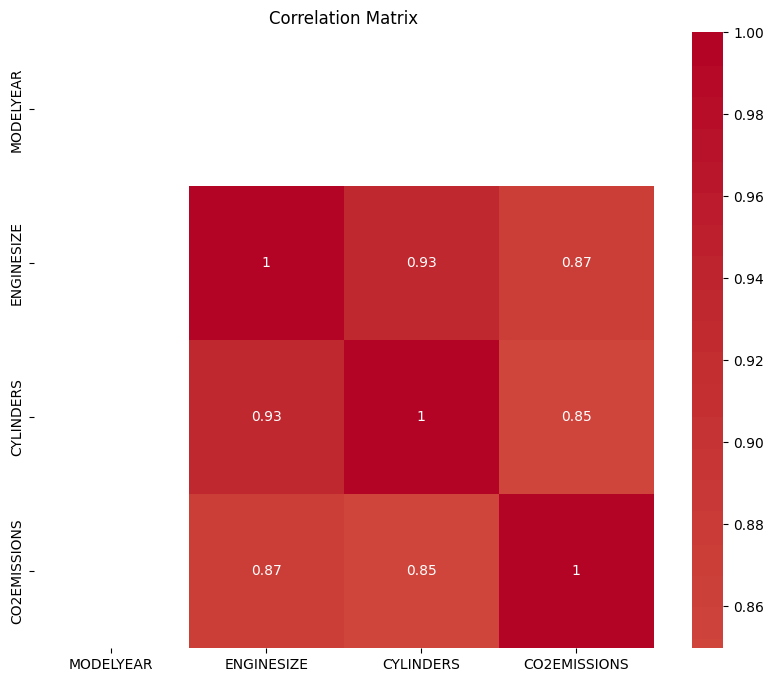

In [7]:
# Correlation matrix
plt.figure(figsize=(10, 8))
corr_matrix = data.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

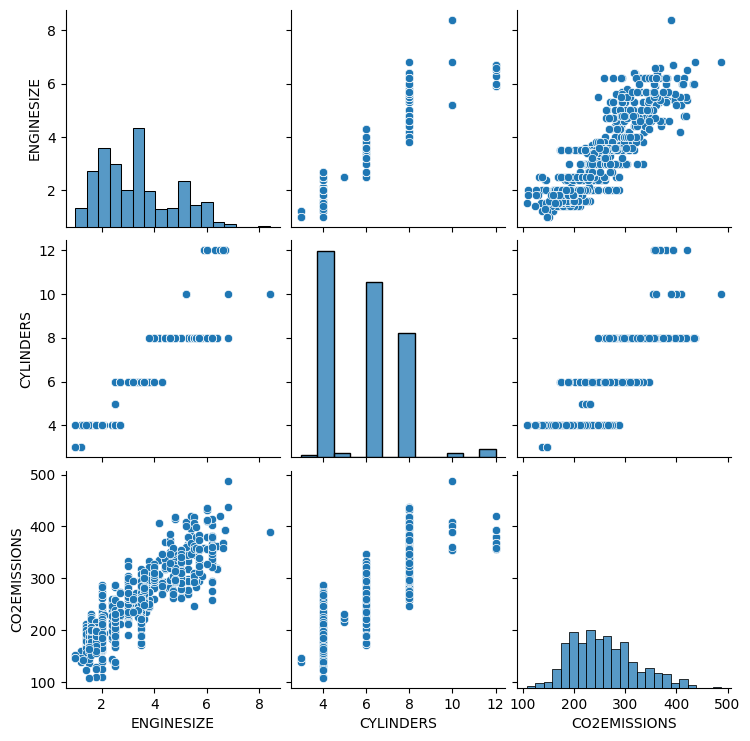

In [ ]:
# Pairplot for key numerical features
sns.pairplot(data=data[['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_CITY', 'FUELCONSUMPTION_HWY', 'CO2EMISSIONS']])
plt.show()

In [10]:
data.describe()

,MODELYEAR,ENGINESIZE,CYLINDERS,CO2EMISSIONS
count,1067.0,1067.000000,1067.000000,1067.000000
mean,2014.0,3.346298,5.794752,256.228679
std,0.0,1.415895,1.797447,63.372304
min,2014.0,1.000000,3.000000,108.000000
25%,2014.0,2.000000,4.000000,207.000000
50%,2014.0,3.400000,6.000000,251.000000
75%,2014.0,4.300000,8.000000,294.000000
max,2014.0,8.400000,12.000000,488.000000


In [11]:
# Feature Engineering
# Create new features that might be relevant
data['FUEL_EFFICIENCY'] = (data['ENGINESIZE'] / data['CYLINDERS'])  # Hypothetical efficiency metric
data['VEHICLE_WEIGHT_TO_POWER'] = data['VEHICLEWEIGHT'] / (data['ENGINESIZE'] * data['CYLINDERS'])


KeyError: 'VEHICLEWEIGHT'

In [12]:
# Handle categorical variables - we'll use one-hot encoding in the pipeline later
print("\nUnique values in categorical features:")
for col in categorical_features:
    print(f"{col}: {data[col].nunique()} unique values")



Unique values in categorical features:
MAKE: 39 unique values
VEHICLECLASS: 16 unique values
TRANSMISSION: 22 unique values
FUELTYPE: 4 unique values


In [13]:
# Prepare data for modeling
X = data.drop(columns=['CO2EMISSIONS'])
y = data['CO2EMISSIONS']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Feature selection and modeling pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k='all')),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define models to try
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'LinearRegression': LinearRegression(),
    'SVR': SVR()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    pipeline.set_params(regressor=model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MSE': mse,
        'RMSE': np.sqrt(mse),
        'R2': r2
    }
    
    print(f"\n{name} Performance:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {np.sqrt(mse):.2f}")
    print(f"R2 Score: {r2:.2f}")


RandomForest Performance:
MSE: 275.09
RMSE: 16.59
R2 Score: 0.93

GradientBoosting Performance:
MSE: 393.50
RMSE: 19.84
R2 Score: 0.90

LinearRegression Performance:
MSE: 347.61
RMSE: 18.64
R2 Score: 0.92

SVR Performance:
MSE: 1501.51
RMSE: 38.75
R2 Score: 0.64


In [16]:
# Compare model performance
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)


Model Comparison:
                          MSE       RMSE        R2
RandomForest       275.094146  16.585962  0.933471
GradientBoosting   393.498929  19.836807  0.904836
LinearRegression   347.613427  18.644394  0.915933
SVR               1501.510935  38.749335  0.636873


In [17]:
# Feature importance for the best model (RandomForest in this case)
best_model = pipeline.named_steps['regressor']
feature_names = numeric_features.tolist()

In [18]:
# Get feature names from one-hot encoding
if len(categorical_features) > 0:
    ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = ohe.get_feature_names_out(categorical_features)
    feature_names.extend(cat_feature_names)

In [19]:
# Get feature importances
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

AttributeError: 'SVR' object has no attribute 'feature_importances_'

In [20]:
# Feature importance analysis (only for models that support it)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Get feature names
    feature_names = numeric_features.tolist()
    
    # Add categorical feature names if they exist
    if len(categorical_features) > 0:
        ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
        cat_feature_names = ohe.get_feature_names_out(categorical_features)
        feature_names.extend(cat_feature_names)

    # Plot feature importances
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(indices)), importances[indices], align="center")
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.xlim([-1, len(indices)])
    plt.tight_layout()
    plt.show()
elif hasattr(best_model, 'coef_'):
    # For linear models, we can look at coefficients
    coefficients = best_model.coef_
    
    # Get feature names
    feature_names = numeric_features.tolist()
    if len(categorical_features) > 0:
        ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
        cat_feature_names = ohe.get_feature_names_out(categorical_features)
        feature_names.extend(cat_feature_names)
    
    # Plot coefficients
    plt.figure(figsize=(12, 6))
    plt.title("Feature Coefficients")
    plt.bar(range(len(coefficients)), coefficients)
    plt.xticks(range(len(coefficients)), feature_names, rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print(f"Model {type(best_model).__name__} doesn't support feature importance or coefficients analysis")

Model SVR doesn't support feature importance or coefficients analysis


NameError: name 'importances' is not defined

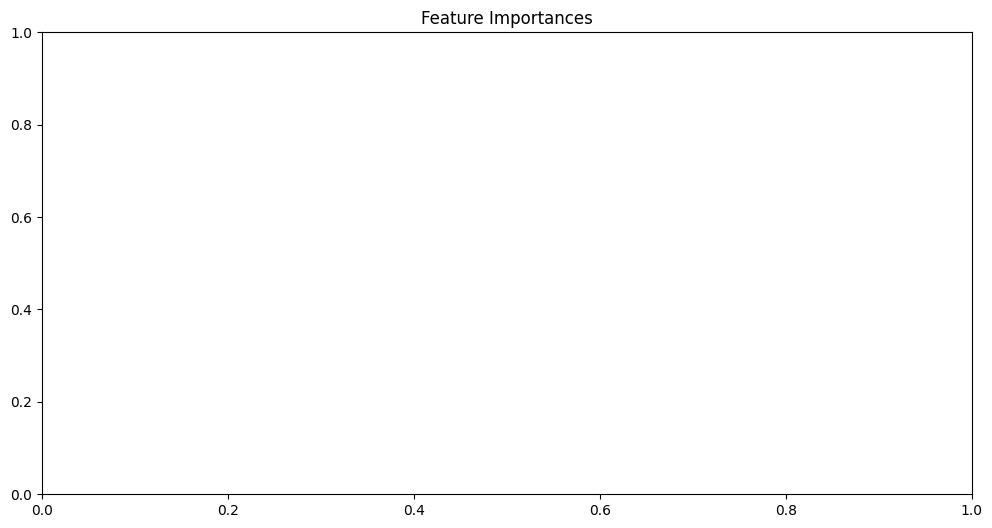

In [21]:
# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()


In [22]:
# Feature importance analysis
if hasattr(best_model, 'feature_importances_'):
    # For tree-based models
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Get feature names from numeric features
    feature_names = numeric_features.tolist()
    
    # Add categorical feature names if they exist
    if len(categorical_features) > 0:
        ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
        cat_feature_names = ohe.get_feature_names_out(categorical_features)
        feature_names.extend(cat_feature_names)
    
    # Plot feature importances
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.tight_layout()
    plt.show()

elif hasattr(best_model, 'coef_'):
    # For linear models
    coefficients = best_model.coef_
    
    # Get feature names
    feature_names = numeric_features.tolist()
    if len(categorical_features) > 0:
        ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
        cat_feature_names = ohe.get_feature_names_out(categorical_features)
        feature_names.extend(cat_feature_names)
    
    # Plot coefficients
    plt.figure(figsize=(12, 6))
    plt.title("Feature Coefficients")
    plt.bar(range(len(coefficients)), coefficients)
    plt.xticks(range(len(coefficients)), feature_names, rotation=90)
    plt.tight_layout()
    plt.show()

else:
    print(f"\nFeature importance not available for {type(best_model).__name__} model")
    print("Consider using permutation importance or SHAP values instead")


Feature importance not available for SVR model
Consider using permutation importance or SHAP values instead


In [23]:
# Hyperparameter tuning for the best model (RandomForest)
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nBest parameters:", grid_search.best_params_)
print("Best score (negative MSE):", grid_search.best_score_)

ValueError: Invalid parameter 'max_depth' for estimator SVR(). Valid parameters are: ['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'].

In [ ]:
# Evaluate the tuned model
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTuned Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {np.sqrt(mse):.2f}")
print(f"R2 Score: {r2:.2f}")

# Save the best model
import joblib
joblib.dump(best_pipeline, 'co2_emissions_model.pkl')

# Load the model for future use
# loaded_model = joblib.load('co2_emissions_model.pkl')


Model Comparison:
                          MSE       RMSE        R2
RandomForest       275.094146  16.585962  0.933471
GradientBoosting   393.498929  19.836807  0.904836
LinearRegression   347.613427  18.644394  0.915933
SVR               1501.510935  38.749335  0.636873


AttributeError: 'SVR' object has no attribute 'feature_importances_'